In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, NormalizeReward, TransformReward
import time
from collections import deque
import random

torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

env = gym.make("LunarLander-v3")
env = RecordEpisodeStatistics(env)
env = TransformReward(env, lambda r: np.clip(r, -10, 10))  
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Using device: cpu
Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [4]:
num_envs = 1
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128  
gnn_dim = 64      
learning_rate = 3e-4
gamma = 0.99
lamda = 0.95
epsilon = 0.2
value_coef = 0.5
entropy_coef = 0.01  
initial_entropy_coef = 0.1  # Start with higher entropy for exploration
final_entropy_coef = 0.001  # End with lower entropy for exploitation
max_grad_norm = 0.5
num_steps = 256  
num_epochs = 10  
batch_size = 64
num_updates = 2000
test_interval = 10

def lr_lambda(epoch):
    return max(1.0 - epoch / num_updates, 0.1)

def state_to_graph(state):
    # Create more informative node features
    # Node 0: Position (x, y)
    # Node 1: Velocity (x, y)
    # Node 2: Angle and angular velocity
    # Node 3: Leg contact sensors
    # Node 4: Combined state (global features)

    # Normalized features to improve learning
    pos_x_norm = state[0] / 2.0  # Typical range [-1, 1]
    pos_y_norm = (state[1] + 0.5) / 1.5  # Typical range [-0.5, 1]
    vel_x_norm = np.clip(state[2] / 2.0, -1, 1)  # Normalize and clip
    vel_y_norm = np.clip(state[3] / 2.0, -1, 1)  # Normalize and clip
    angle_norm = state[4] / np.pi  # Normalize angle
    ang_vel_norm = np.clip(state[5] / 5.0, -1, 1)  # Normalize and clip

    node_features = torch.tensor([
        [pos_x_norm, pos_y_norm, vel_x_norm * 0.5, vel_y_norm * 0.5, angle_norm * 0.2, 0, state[6], state[7]],  # Position with velocity influence
        [pos_x_norm * 0.5, pos_y_norm * 0.5, vel_x_norm, vel_y_norm, ang_vel_norm * 0.5, 0, 0, 0],  # Velocity with position influence
        [pos_x_norm * 0.2, pos_y_norm * 0.2, 0, 0, angle_norm, ang_vel_norm, 0, 0],  # Angle with position influence
        [0, pos_y_norm * 0.7, 0, vel_y_norm * 0.7, 0, 0, state[6], state[7]],  # Leg contacts with position and velocity influence
        [pos_x_norm, pos_y_norm, vel_x_norm, vel_y_norm, angle_norm, ang_vel_norm, state[6], state[7]]  # Global state node
    ], dtype=torch.float)
    
    # Create edge indices - fully connected graph with directed edges
    edge_index = torch.tensor([
        [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],  # Source nodes
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]   # Target nodes
    ], dtype=torch.long)
    
    edge_attr = torch.ones(edge_index.shape[1], 1, dtype=torch.float)
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [5]:
class ImprovedGNNActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, gnn_dim):
        super(ImprovedGNNActorCritic, self).__init__()
        
        self.conv1 = GCNConv(8, gnn_dim)
        self.gat1 = GATConv(gnn_dim, gnn_dim, heads=2)
        self.conv2 = GCNConv(gnn_dim * 2, gnn_dim)  
        
        self.fc_shared1 = nn.Linear(gnn_dim, hidden_dim)
        self.fc_shared2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc_actor = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_critic = nn.Linear(hidden_dim, hidden_dim // 2)
        
        self.actor = nn.Linear(hidden_dim // 2, action_dim)
        self.critic = nn.Linear(hidden_dim // 2, 1)
        
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm_actor = nn.LayerNorm(hidden_dim // 2)
        self.layer_norm_critic = nn.LayerNorm(hidden_dim // 2)
    
    def forward(self, data):
        if isinstance(data, list):
            data = Batch.from_data_list(data)
        
        x, edge_index = data.x, data.edge_index
        
        x1 = F.elu(self.conv1(x, edge_index))
        x2 = self.gat1(x1, edge_index)
        x = F.elu(self.conv2(x2, edge_index))
        
        x_mean = global_mean_pool(x, data.batch)
        x_sum = global_add_pool(x, data.batch)
        x = torch.cat([x_mean, x_sum], dim=1) if data.batch is not None else torch.cat([x.mean(dim=0, keepdim=True), x.sum(dim=0, keepdim=True)], dim=1)
        
        shared_features = F.elu(self.fc_shared1(x_mean))  
        shared_features = self.layer_norm1(shared_features)
        shared_features = F.elu(self.fc_shared2(shared_features))
        shared_features = self.layer_norm2(shared_features)
        
        actor_features = F.elu(self.fc_actor(shared_features))
        actor_features = self.layer_norm_actor(actor_features)
        
        critic_features = F.elu(self.fc_critic(shared_features))
        critic_features = self.layer_norm_critic(critic_features)
        
        action_logits = self.actor(actor_features)
        action_probs = F.softmax(action_logits, dim=1)
        
        # State value
        state_value = self.critic(critic_features)
        
        return action_probs, state_value

model = ImprovedGNNActorCritic(state_dim, action_dim, hidden_dim, gnn_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [6]:
def ppo_update(model, optimizer, states, actions, old_log_probs, returns, advantages, update_idx):
    
    states_batch = Batch.from_data_list(states).to(device)
    actions_batch = torch.tensor(actions, dtype=torch.long).to(device)
    old_log_probs_batch = torch.tensor(old_log_probs, dtype=torch.float).to(device)
    returns_batch = torch.tensor(returns, dtype=torch.float).to(device)
    advantages_batch = torch.tensor(advantages, dtype=torch.float).to(device)
    
    advantages_batch = (advantages_batch - advantages_batch.mean()) / (advantages_batch.std() + 1e-8)
    
    progress = min(update_idx / (num_updates * 0.8), 1.0)  # Progress ratio, capped at 1.0
    entropy_coef = initial_entropy_coef * (1 - progress) + final_entropy_coef * progress
    
    policy_losses = []
    value_losses = []
    entropies = []
    kl_divs = []
    early_stop = False
    
    for epoch in range(num_epochs):
        if early_stop:
            break
            
        indices = np.random.permutation(len(states))
        for start_idx in range(0, len(states), batch_size):
            end_idx = min(start_idx + batch_size, len(states))
            batch_indices = indices[start_idx:end_idx]
            
            mb_states_list = [states[i] for i in batch_indices]
            mb_states = Batch.from_data_list(mb_states_list).to(device)
            mb_actions = actions_batch[batch_indices]
            mb_old_log_probs = old_log_probs_batch[batch_indices]
            mb_returns = returns_batch[batch_indices]
            mb_advantages = advantages_batch[batch_indices]
            
            action_probs, state_values = model(mb_states)
            state_values = state_values.squeeze()
            
            dist = torch.distributions.Categorical(action_probs)
            new_log_probs = dist.log_prob(mb_actions)
            entropy = dist.entropy().mean()
            
            # Compute KL divergence for early stopping
            with torch.no_grad():
                old_action_probs, _ = model(mb_states)
                old_dist = torch.distributions.Categorical(old_action_probs)
                kl_div = torch.distributions.kl_divergence(old_dist, dist).mean()
                kl_divs.append(kl_div.item())
                
                # Early stopping based on KL divergence
                if kl_div > 0.015:
                    early_stop = True
                    break
            
            ratio = torch.exp(new_log_probs - mb_old_log_probs)
            
            surr1 = ratio * mb_advantages
            surr2 = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) * mb_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            value_pred_clipped = mb_returns + torch.clamp(
                state_values - mb_returns, -epsilon, epsilon
            )
            value_loss = torch.max(
                F.mse_loss(state_values, mb_returns, reduction='none'),
                F.mse_loss(value_pred_clipped, mb_returns, reduction='none')
            ).mean()
            
            loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            
            policy_losses.append(actor_loss.item())
            value_losses.append(value_loss.item())
            entropies.append(entropy.item())
    
    return {
        'policy_loss': np.mean(policy_losses),
        'value_loss': np.mean(value_losses),
        'entropy': np.mean(entropies),
        'kl_div': np.mean(kl_divs),
        'early_stopped': early_stop
    }

def collect_trajectories():
    states = []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    values = []
    
    state, _ = env.reset()
    done = False
    
    for _ in range(num_steps):
        
        state_graph = state_to_graph(state)
        states.append(state_graph)
        
        with torch.no_grad():
            action_probs, value = model([state_graph.to(device)])
            
            exploration_factor = 0.1
            noise = torch.rand_like(action_probs) * exploration_factor
            action_probs = F.softmax(torch.log(action_probs + 1e-8) + noise, dim=1)
            
            dist = torch.distributions.Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        actions.append(action.item())
        log_probs.append(log_prob.item())
        rewards.append(reward)
        dones.append(done)
        values.append(value.item())
        
        state = next_state
        
        if done:
            state, _ = env.reset()
            done = False
    
    returns = []
    advantages = []
    
    with torch.no_grad():
        if not done:
            last_state_graph = state_to_graph(state)
            _, last_value = model([last_state_graph.to(device)])
            last_value = last_value.item()
        else:
            last_value = 0
    
    gae = 0
    running_return = last_value
    
    for t in reversed(range(len(rewards))):
        if t == len(rewards) - 1:
            next_non_terminal = 1.0 - dones[t]
            next_value = last_value
        else:
            next_non_terminal = 1.0 - dones[t]
            next_value = values[t + 1]
        
        delta = rewards[t] + gamma * next_value * next_non_terminal - values[t]
        gae = delta + gamma * lamda * next_non_terminal * gae
        
        running_return = rewards[t] + gamma * next_non_terminal * running_return
        
        returns.insert(0, running_return)
        advantages.insert(0, gae)
    
    return states, actions, log_probs, returns, advantages

def evaluate_policy(model, num_episodes=10):
    eval_env = gym.make("LunarLander-v3", render_mode="rgb_array")
    eval_rewards = []
    success_count = 0
    
    for _ in range(num_episodes):
        state, _ = eval_env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            state_graph = state_to_graph(state)
            with torch.no_grad():
                action_probs, _ = model([state_graph.to(device)])
                action = torch.argmax(action_probs).item()
            
            next_state, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        
        eval_rewards.append(episode_reward)
        if episode_reward > 200:
            success_count += 1
    
    success_rate = success_count / num_episodes
    eval_env.close()
    return np.mean(eval_rewards), success_rate

In [ ]:
os.makedirs("models", exist_ok=True)

rewards_history = []
success_rates = []
best_reward = -float('inf')
best_model_path = None
patience = 20  # For early stopping
patience_counter = 0

buffer_capacity = 10000
replay_buffer = deque(maxlen=buffer_capacity)

for update in range(1, num_updates + 1):
    start_time = time.time()
    
    states, actions, log_probs, returns, advantages = collect_trajectories()
    
    for i in range(len(states)):
        replay_buffer.append((states[i], actions[i], log_probs[i], returns[i], advantages[i]))
    
    if len(replay_buffer) > batch_size * 10:
        buffer_sample = random.sample(replay_buffer, min(len(replay_buffer) // 2, num_steps))
        buffer_states, buffer_actions, buffer_log_probs, buffer_returns, buffer_advantages = zip(*buffer_sample)
        
        # Mix current experiences with replay buffer
        mixed_states = states[:num_steps//2] + list(buffer_states)[:num_steps//2]
        mixed_actions = actions[:num_steps//2] + list(buffer_actions)[:num_steps//2]
        mixed_log_probs = log_probs[:num_steps//2] + list(buffer_log_probs)[:num_steps//2]
        mixed_returns = returns[:num_steps//2] + list(buffer_returns)[:num_steps//2]
        mixed_advantages = advantages[:num_steps//2] + list(buffer_advantages)[:num_steps//2]
    else:
        mixed_states = states
        mixed_actions = actions
        mixed_log_probs = log_probs
        mixed_returns = returns
        mixed_advantages = advantages
    
    update_info = ppo_update(model, optimizer, mixed_states, mixed_actions, mixed_log_probs, mixed_returns, mixed_advantages, update)
    
    # Update learning rate
    scheduler.step()
    
    # Evaluate
    if update % test_interval == 0:
        mean_reward, success_rate = evaluate_policy(model)
        rewards_history.append(mean_reward)
        success_rates.append(success_rate)
        
        print(f"Update: {update}/{num_updates}, Mean Reward: {mean_reward:.2f}, Success Rate: {success_rate:.2f}, Time: {time.time() - start_time:.2f}s")
        print(f"Policy Loss: {update_info['policy_loss']:.4f}, Value Loss: {update_info['value_loss']:.4f}, Entropy: {update_info['entropy']:.4f}, KL Div: {update_info['kl_div']:.4f}")
        
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_model_path = f"models/gnn_ppo_lunar_lander_best_after.pt"
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print(f"New best model saved with reward: {best_reward:.2f}")
        else:
            patience_counter += 1

        if patience_counter >= patience and mean_reward > 200:
            print(f"Early stopping after {patience} evaluations without improvement. Best reward: {best_reward:.2f}")
            break


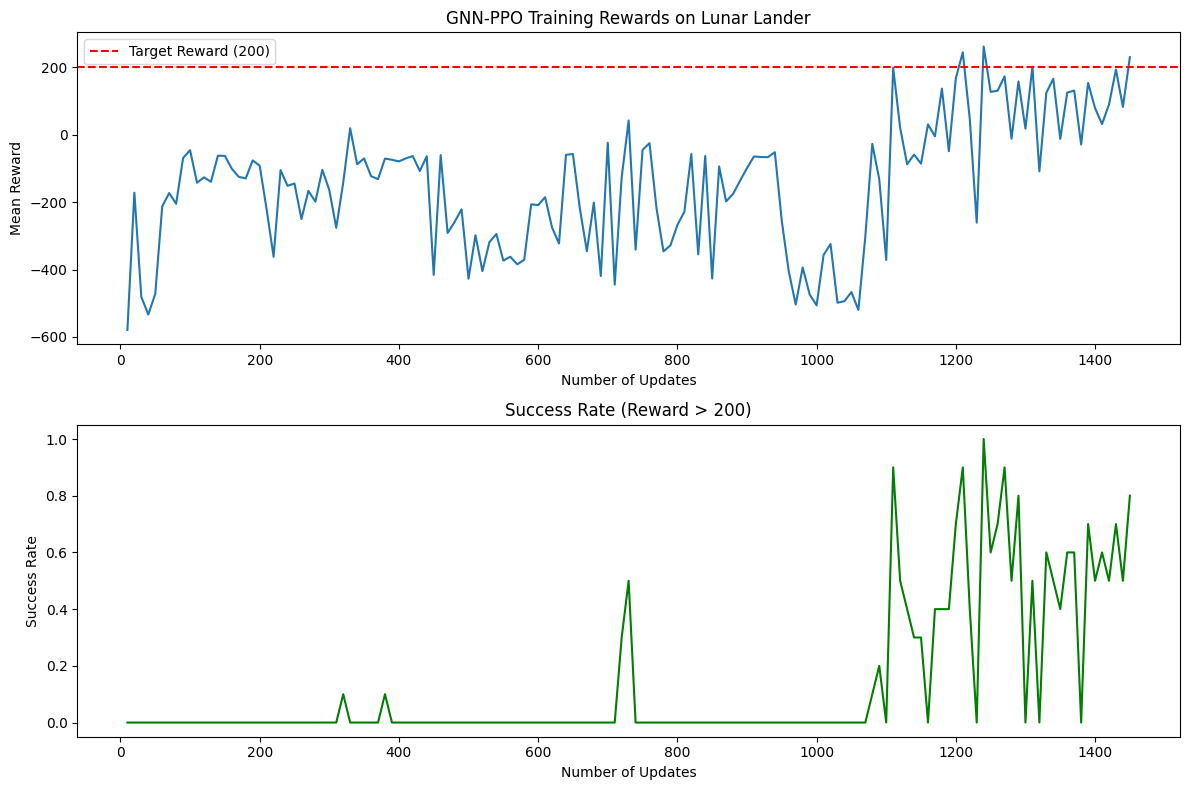

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot rewards`
plt.subplot(2, 1, 1)
plt.plot(range(test_interval, (len(rewards_history) + 1) * test_interval, test_interval), rewards_history)
plt.axhline(y=200, color='r', linestyle='--', label='Target Reward (200)')
plt.xlabel("Number of Updates")
plt.ylabel("Mean Reward")
plt.title("GNN-PPO Training Rewards on Lunar Lander")
plt.legend()

# Plot success rates
plt.subplot(2, 1, 2)
plt.plot(range(test_interval, (len(success_rates) + 1) * test_interval, test_interval), success_rates, color='green')
plt.xlabel("Number of Updates")
plt.ylabel("Success Rate")
plt.title("Success Rate (Reward > 200)")
plt.tight_layout()

plt.savefig("gnn_ppo_training_progress.png")
plt.show()


In [16]:
def detailed_evaluation(model, num_episodes=20):
    eval_env = gym.make("LunarLander-v3", render_mode="rgb_array")
    all_rewards = []
    success_count = 0
    crash_count = 0
    timeout_count = 0
    step_counts = []
    
    for episode in range(num_episodes):
        state, _ = eval_env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        while not done:
            state_graph = state_to_graph(state)
            with torch.no_grad():
                action_probs, _ = model([state_graph.to(device)])
                action = torch.argmax(action_probs).item()
            
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
            steps += 1
        
        all_rewards.append(episode_reward)
        step_counts.append(steps)
        
        if episode_reward > 200:
            success_count += 1
        elif terminated and episode_reward < 0:
            crash_count += 1
        elif truncated:
            timeout_count += 1
    
    # Calculate statistics
    mean_reward = np.mean(all_rewards)
    std_reward = np.std(all_rewards)
    success_rate = success_count / num_episodes
    crash_rate = crash_count / num_episodes
    timeout_rate = timeout_count / num_episodes
    mean_steps = np.mean(step_counts)
    
    print("\n=== Detailed Evaluation Results ===")
    print(f"Number of Episodes: {num_episodes}")
    print(f"Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"Success Rate: {success_rate:.2f} ({success_count}/{num_episodes})")
    print(f"Crash Rate: {crash_rate:.2f} ({crash_count}/{num_episodes})")
    print(f"Timeout Rate: {timeout_rate:.2f} ({timeout_count}/{num_episodes})")
    print(f"Mean Steps per Episode: {mean_steps:.2f}")
    print(f"Reward Range: [{min(all_rewards):.2f}, {max(all_rewards):.2f}]")
    print("===================================\n")
    
    eval_env.close()
    return mean_reward, success_rate

# Load and evaluate the best model
# print("\nEvaluating best model...")
# best_model_path = r"C:\Users\rajur\Projects\Moon Landing RL\models\gnn_ppo_lunar_lander_best_after.pt"
# model.load_state_dict(torch.load(best_model_path))
final_reward, final_success_rate = detailed_evaluation(model)



=== Detailed Evaluation Results ===
Number of Episodes: 20
Mean Reward: 271.14 ± 22.67
Success Rate: 1.00 (20/20)
Crash Rate: 0.00 (0/20)
Timeout Rate: 0.00 (0/20)
Mean Steps per Episode: 258.25
Reward Range: [225.27, 302.88]



In [15]:
def render_policy(model, num_episodes=5):
    render_env = gym.make("LunarLander-v3", render_mode="human")
    
    for episode in range(num_episodes):
        state, _ = render_env.reset()
        episode_reward = 0
        done = False
        step = 0
        
        while not done:
            state_graph = state_to_graph(state)
            with torch.no_grad():
                action_probs, _ = model([state_graph.to(device)])
                action = torch.argmax(action_probs).item()
            
            next_state, reward, terminated, truncated, _ = render_env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
            step += 1
        
        print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Steps = {step}")
    
    render_env.close()

print("\nRendering best model performance...")
render_policy(model)

# Clean up
env.close()
print("\nTraining complete!")


Rendering best model performance...
Episode 1: Reward = 254.79, Steps = 273
Episode 2: Reward = 287.58, Steps = 232
Episode 3: Reward = 268.80, Steps = 226
Episode 4: Reward = 239.88, Steps = 238
Episode 5: Reward = 239.03, Steps = 252

Training complete!


In [14]:
import torch
import imageio

def render_and_record(model, num_episodes=2, video_filename="lunar_lander_1.mp4"):
    render_env = gym.make("LunarLander-v3", render_mode="rgb_array")  # Use rgb_array for recording
    frames = []  # List to store video frames

    for episode in range(num_episodes):
        state, _ = render_env.reset()
        episode_reward = 0
        done = False
        step = 0

        while not done:
            # Capture frame
            frame = render_env.render()
            frames.append(frame)

            # Get action from the model
            state_graph = state_to_graph(state)
            with torch.no_grad():
                action_probs, _ = model([state_graph.to(device)])
                action = torch.argmax(action_probs).item()

            next_state, reward, terminated, truncated, _ = render_env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
            step += 1

        print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Steps = {step}")

    render_env.close()

    # Save frames as a video
    imageio.mimsave(video_filename, frames, fps=30)
    print(f"Video saved as {video_filename}")


best_model_path = r"C:\Users\rajur\Projects\Moon Landing RL\models\gnn_ppo_lunar_lander_best_after.pt"
model.load_state_dict(torch.load(best_model_path))

print("\nRendering and recording the best model performance...")
render_and_record(model)

print("\nTraining complete!")

C:\Users\rajur\AppData\Local\Temp\ipykernel_20364\3574987447.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Rendering and recording the best model performance...
Episode 1: Reward = 298.07, Steps = 219


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 2: Reward = 283.79, Steps = 208
Video saved as lunar_lander_1.mp4

Training complete!
